# Age Estimation by Voice: Speech Analysis Approaches

*Academic Year:* 2024/2025

### Team Members (Alphabetical Order):
1. Banaudi Alice (347490);
2. Finocchiaro Carla (337024).

In [5]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa

# Machine Learning Tools
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Table for Model Evaluation
from prettytable import PrettyTable

## Loading the datasets

In [6]:
dev_df=pd.read_csv('./data/development.csv')

In [7]:
display(dev_df)

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,24.0,female,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,22.5,female,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,22.0,female,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,22.0,female,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,22.0,male,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2928,22050,24.0,male,english,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,[184.5703125],-100.921055,69,281,11,17.461406,audios_development/2929.wav
2929,2929,22050,15.0,female,igbo,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,[83.35433468],6.757283,0,0,1,1.509206,audios_development/2930.wav
2930,2930,22050,17.0,female,igbo,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,[89.10290948],-53.913449,1,9,1,1.645034,audios_development/2931.wav
2931,2931,22050,18.0,male,arabic,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.004451,0.115139,1834.596924,[143.5546875],-96.143090,69,281,19,16.346848,audios_development/2932.wav


In [8]:
eval_df=pd.read_csv('./data/evaluation.csv')
display(eval_df)

,Id,sampling_rate,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503,audios_evaluation/1.wav
1,1,22050,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442,audios_evaluation/2.wav
2,2,22050,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556,audios_evaluation/3.wav
3,3,22050,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837,audios_evaluation/4.wav
4,4,22050,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476,audios_evaluation/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,686,22050,male,igbo,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,[112.34714674],-42.895295,6,15,1,1.861950,audios_evaluation/687.wav
687,687,22050,male,igbo,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,[112.34714674],-144.881089,7,22,1,4.876190,audios_evaluation/688.wav
688,688,22050,female,serbian,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,[112.34714674],-73.559944,69,281,15,25.541950,audios_evaluation/689.wav
689,689,22050,male,spanish,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,[117.45383523],-93.562873,69,281,10,20.967619,audios_evaluation/690.wav


## Data exploration

In [9]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2933 non-null   int64  
 1   sampling_rate           2933 non-null   int64  
 2   age                     2933 non-null   float64
 3   gender                  2933 non-null   object 
 4   ethnicity               2933 non-null   object 
 5   mean_pitch              2933 non-null   float64
 6   max_pitch               2933 non-null   float64
 7   min_pitch               2933 non-null   float64
 8   jitter                  2933 non-null   float64
 9   shimmer                 2933 non-null   float64
 10  energy                  2933 non-null   float64
 11  zcr_mean                2933 non-null   float64
 12  spectral_centroid_mean  2933 non-null   float64
 13  tempo                   2933 non-null   object 
 14  hnr                     2933 non-null   

We can see that there are no missing values in the dataset and we already have 18 features, including our target (age).

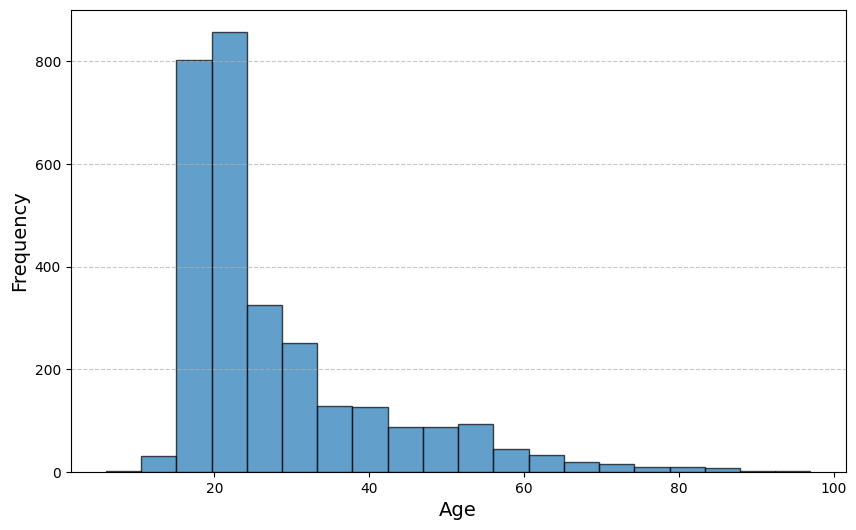

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(dev_df['age'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that the distribution of the target variable age is not uniform, so the model will tend to learn better how to guess the age of the people in their twenties. 

## Data cleaning and transformation 

We decide to combine the development  and evaluation dataframes, so any transformation that we do to one is done to the other too. Moreover, we drop the our target age and save it in another variable for later.

In [11]:
Y_dev= dev_df['age'].values
dev_df.drop(columns=['age'], inplace=True)

In [12]:
#df = dev_df
df = pd.concat([dev_df, eval_df], ignore_index=True)
display(df)

,Id,sampling_rate,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,female,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,female,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,female,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,female,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,male,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,686,22050,male,igbo,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,[112.34714674],-42.895295,6,15,1,1.861950,audios_evaluation/687.wav
3620,687,22050,male,igbo,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,[112.34714674],-144.881089,7,22,1,4.876190,audios_evaluation/688.wav
3621,688,22050,female,serbian,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,[112.34714674],-73.559944,69,281,15,25.541950,audios_evaluation/689.wav
3622,689,22050,male,spanish,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,[117.45383523],-93.562873,69,281,10,20.967619,audios_evaluation/690.wav


We have two categorical features: gender and etnicity, we only use the first one in our analysis, as we belive ethnicity is not an important feature for guessing the age of a person.

Since there is a mispelling of the gender female, we replace the error and then do label enconding. 

In [13]:
df["gender"].unique()

array(['female', 'male', 'famale'], dtype=object)

In [14]:
df["gender"] = df["gender"].replace("famale", "female")

In [15]:
df["gender"] = df["gender"].map({"female": 1, "male": 0})

In [16]:
display(df)

,Id,sampling_rate,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,1,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,1,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,1,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,1,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,0,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,686,22050,0,igbo,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,[112.34714674],-42.895295,6,15,1,1.861950,audios_evaluation/687.wav
3620,687,22050,0,igbo,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,[112.34714674],-144.881089,7,22,1,4.876190,audios_evaluation/688.wav
3621,688,22050,1,serbian,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,[112.34714674],-73.559944,69,281,15,25.541950,audios_evaluation/689.wav
3622,689,22050,0,spanish,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,[117.45383523],-93.562873,69,281,10,20.967619,audios_evaluation/690.wav


In [17]:
display(df)

,Id,sampling_rate,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,1,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,1,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,1,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,1,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,0,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,686,22050,0,igbo,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,[112.34714674],-42.895295,6,15,1,1.861950,audios_evaluation/687.wav
3620,687,22050,0,igbo,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,[112.34714674],-144.881089,7,22,1,4.876190,audios_evaluation/688.wav
3621,688,22050,1,serbian,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,[112.34714674],-73.559944,69,281,15,25.541950,audios_evaluation/689.wav
3622,689,22050,0,spanish,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,[117.45383523],-93.562873,69,281,10,20.967619,audios_evaluation/690.wav


We can also note that tempo is considered an object in the dataset, as it is treated as a list. So we convert it in float by deleting the parenthesis.

In [18]:
df['tempo'] = df['tempo'].str.replace('[','').str.replace(']','').astype(float)


## Feature extraction

To extract additional features from the audio, we use librosa library to load the audios and then to compute the mel coefficients and some spectral features such as the spectral rolloff and  bandwidth.

In [19]:
x_list = []
sr_list = []
mfcc_list = []

spec_roll_mean_list = []
spec_roll_std_list = []

spec_band_mean_list = []
spec_band_std_list = []


for index, row in df.iterrows():
    full_path = './data/' + row['path']

    # Load the audios
    x, sr = librosa.load(full_path)

    # Compute MFCC
    mfccs = np.mean(librosa.power_to_db(librosa.feature.mfcc(y=x, n_mfcc=13, sr=sr), ref=np.max), axis=1)
    
    # Compute spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x + 0.01, sr=sr)[0]
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    spectral_rolloff_std = np.std(spectral_rolloff)
  
    # Compute spectral bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=x, sr=sr)[0]
    spec_band_mean = np.mean(spec_band)
    spec_band_std = np.std(spec_band)


    # Append the computed features
    x_list.append(x)
    sr_list.append(sr)
    mfcc_list.append(mfccs)

    spec_roll_mean_list.append(spectral_rolloff_mean)
    spec_roll_std_list.append(spectral_rolloff_std)


    spec_band_mean_list.append(spec_band_mean)
    spec_band_std_list.append(spec_band_std)
  

Now that we have in a list all the audios, we visualize the first one in the time domain and its corresponding melspectrogram.

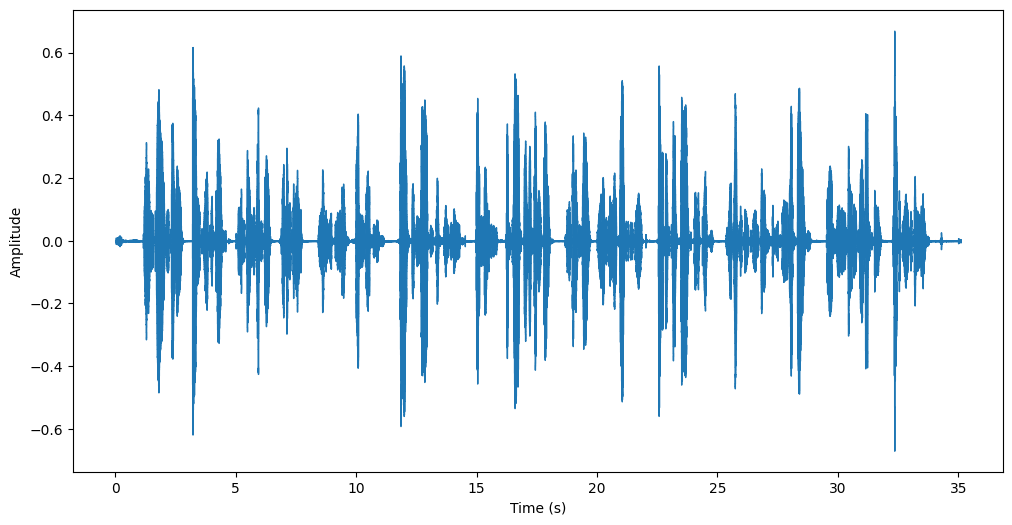

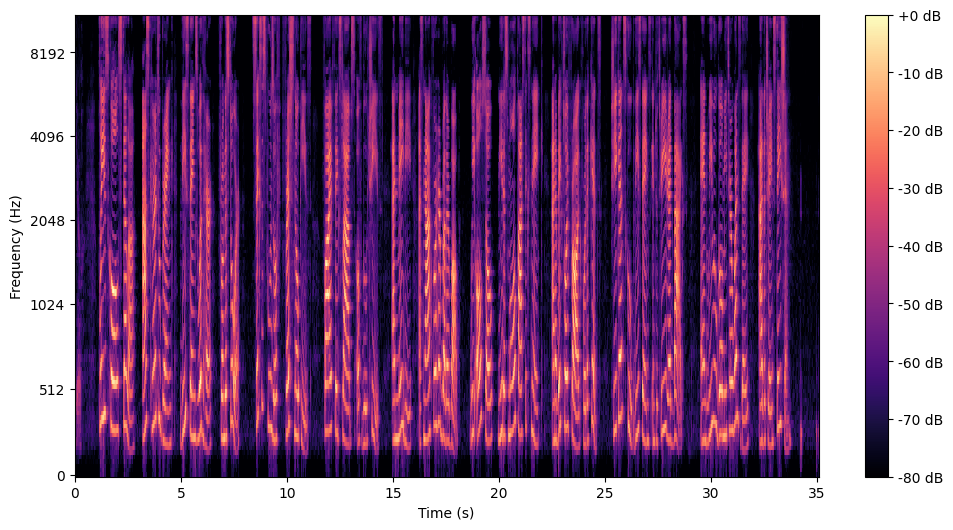

In [20]:
x_1 = x_list[0]  
sr_1 = sr_list[0]  

plt.figure(figsize=(12, 6))
librosa.display.waveshow(x_1, sr=sr_1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show() 

plt.figure(figsize=(12, 6))
mel_spectrogram = librosa.feature.melspectrogram(y=x_1, sr=sr_1, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr_1)
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show() 

We also want to create new features using the ones in the dataset, so we defined two function: one to get the duration of audios and the other computes the rate of speeach of each person.

In [21]:
def get_audio_duration_librosa(audio_data, sr):
    try:
        duration = librosa.get_duration(y=audio_data, sr=sr)
        return duration
    except Exception as e:
        print(f"Errore nel calcolo della durata con librosa: {e}")
        return None

In [22]:
def calculate_rate_of_speech(df, x_list, sr_list):
    rate_of_speech_values = []
    
    for audio, sr, num_words in zip(x_list, sr_list, df['num_words']):
        # Compute the duration of the audio
        duration = get_audio_duration_librosa(audio, sr)
        
        # Compute the rate of speech
        if duration and duration > 0:
            rate_of_speech = num_words / duration
        else:
            rate_of_speech = None
        
        # Append the result
        rate_of_speech_values.append(rate_of_speech)
    
    # Create a new column in the datafram for the feature
    df['rate_of_speech'] = rate_of_speech_values
    
    return df

In [23]:
df = calculate_rate_of_speech(df, x_list, sr_list)


In [24]:
display(df)

,Id,sampling_rate,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path,rate_of_speech
0,0,22050,1,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893,audios_development/1.wav,1.966079
1,1,22050,1,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662,audios_development/2.wav,2.957402
2,2,22050,1,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998,audios_development/3.wav,3.184435
3,3,22050,1,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127,audios_development/4.wav,3.069810
4,4,22050,0,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905,audios_development/5.wav,3.614402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,686,22050,0,igbo,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,112.347147,-42.895295,6,15,1,1.861950,audios_evaluation/687.wav,2.963710
3620,687,22050,0,igbo,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,112.347147,-144.881089,7,22,1,4.876190,audios_evaluation/688.wav,1.414939
3621,688,22050,1,serbian,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,112.347147,-73.559944,69,281,15,25.541950,audios_evaluation/689.wav,2.510432
3622,689,22050,0,spanish,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,117.453835,-93.562873,69,281,10,20.967619,audios_evaluation/690.wav,3.189623


In [25]:
for i in range(13):
    # Create a column in the dataframe for each MFCC
    df[f"MFCC_{i+1}"] = [mfcc[i] for mfcc in mfcc_list]

In [26]:
#Create the columns for the spectral features
df["mean_spectral_rolloff"] = spec_roll_mean_list
df["std_spectral_rolloff"] = spec_roll_std_list

df["mean_spec_band"] = spec_band_mean_list
df["std_spec_band"] = spec_band_std_list


The last feature we compute is pitch_range. After that we drop all the columns that will be useless in the training of the model.

In [27]:
df["pitch_range"] = df["max_pitch"] - df["min_pitch"]

In [28]:
df = df.drop(columns=["Id", "path", "sampling_rate","ethnicity"])

In [29]:
display(df)

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,mean_spectral_rolloff,std_spectral_rolloff,mean_spec_band,std_spec_band,pitch_range
0,1,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,...,-78.588921,-69.377762,-78.386253,-46.280132,-73.096657,4300.061035,2460.937151,2297.006714,666.904361,3854.28634
1,1,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,...,-37.894669,-62.639519,-66.761574,-46.323341,-72.384598,3089.736109,1900.741844,1902.185294,651.417184,3853.48632
2,1,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,...,-58.963436,-26.393101,-44.497116,-45.374157,-38.255394,4676.601343,2335.449446,2547.991669,446.763793,3853.37855
3,1,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,...,-73.404121,-63.042889,-50.150436,-69.212471,-70.148232,4734.538038,2997.042550,2411.285176,631.025672,3850.47017
4,0,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,...,-75.514534,-50.401180,-43.778351,-65.983948,-40.421505,3393.140924,2340.768754,1960.817778,641.817377,3853.16358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,0,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,112.347147,...,-53.970776,-45.178871,-36.874840,-66.370651,-51.162430,3735.521351,2812.978911,2358.166765,723.081508,3754.99723
3620,0,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,112.347147,...,-68.686890,-12.167247,-23.978361,-71.695648,-17.912672,6806.001524,2412.068859,3118.188132,548.534873,3773.09832
3621,1,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,112.347147,...,-48.558533,-54.823143,-53.073677,-30.944550,-49.706043,3384.513937,2804.810579,2103.063765,742.093724,3853.96793
3622,0,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,117.453835,...,-27.628141,-72.951729,-22.536640,-60.788818,-42.627899,3869.264765,986.951074,1599.312265,272.337582,3853.89327


# Training and testing

In [30]:
X = df[:2933]
y = Y_dev

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

# Standardize X and y
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [31]:
# Degree for polynomial features
degree = 5

# List of models and their names
models = [
    LinearRegression(),
    Ridge(random_state=17),
    RandomForestRegressor(n_estimators=300, random_state=17),
    ExtraTreesRegressor(n_estimators=300, random_state=17),
    KNeighborsRegressor(n_neighbors=5),
    make_pipeline(
        make_column_transformer(
            (FunctionTransformer(np.sin), [0]),
            (PolynomialFeatures(degree), [0])
        ),
        LinearRegression()
    ),
    make_pipeline(
        make_column_transformer(
            (FunctionTransformer(np.sin), [0]),
            (PolynomialFeatures(degree), [0])
        ),
        Ridge(alpha=1)
    )
]

names = [
    'linreg',
    'ridge',
    'rf',
    'extra_trees',
    'knn',
    f'sin+poly{degree}+linreg',
    f'sin+poly{degree}+ridge'
]

# PrettyTable for results
t = PrettyTable()
t.field_names = ['Model', 'RMSE']

# Test each model
for model, name in zip(models, names):
    try:
        # Check if the model requires standardized data
        if isinstance(model, (LinearRegression, Ridge)):
            model.fit(X_train_scaled, y_train)
            y_test_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        t.add_row([name, f"{rmse:.4f}"])
    except Exception as e:
        # Handle errors during fitting or prediction
        t.add_row([name, "Error"])

# Print the results table
print(t)

+------------------+---------+
|      Model       |   RMSE  |
+------------------+---------+
|      linreg      | 10.1391 |
|      ridge       | 10.1381 |
|        rf        |  9.8243 |
|   extra_trees    |  9.9229 |
|       knn        | 12.0280 |
| sin+poly5+linreg | 12.9109 |
| sin+poly5+ridge  | 12.9109 |
+------------------+---------+


In [32]:
# Base model
rf = RandomForestRegressor(random_state=17)

# Hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Metric RMSE
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [33]:
best_params['random_state'] = 17
optimized_rf = RandomForestRegressor(**best_params)

# Train the new model
optimized_rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=17)

In [34]:
# Evaluation of the model
y_pred_rf = optimized_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("RMSE on test set:", rmse_rf)


RMSE on test set: 9.938117423098445


In [35]:
#  Base model
etr = ExtraTreesRegressor(random_state=17)

# Hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=etr,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Metric RMSE
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [36]:
# Create a new model with the best hyperparameters
optimized_etr = ExtraTreesRegressor(bootstrap= False, max_depth= None, max_features= None, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 100,
                                    random_state=17)

# Train the new model on the training data
optimized_etr.fit(X_train, y_train)

#Evaluation of the model
y_pred_etr = optimized_etr.predict(X_test)
r2_etr = r2_score(y_test, y_pred_etr)
mse_etr = mean_squared_error(y_test, y_pred_etr)
rmse_etr = np.sqrt(mse_etr)
print("RMSE on test set:", rmse_etr)


RMSE on test set: 9.770349801941014


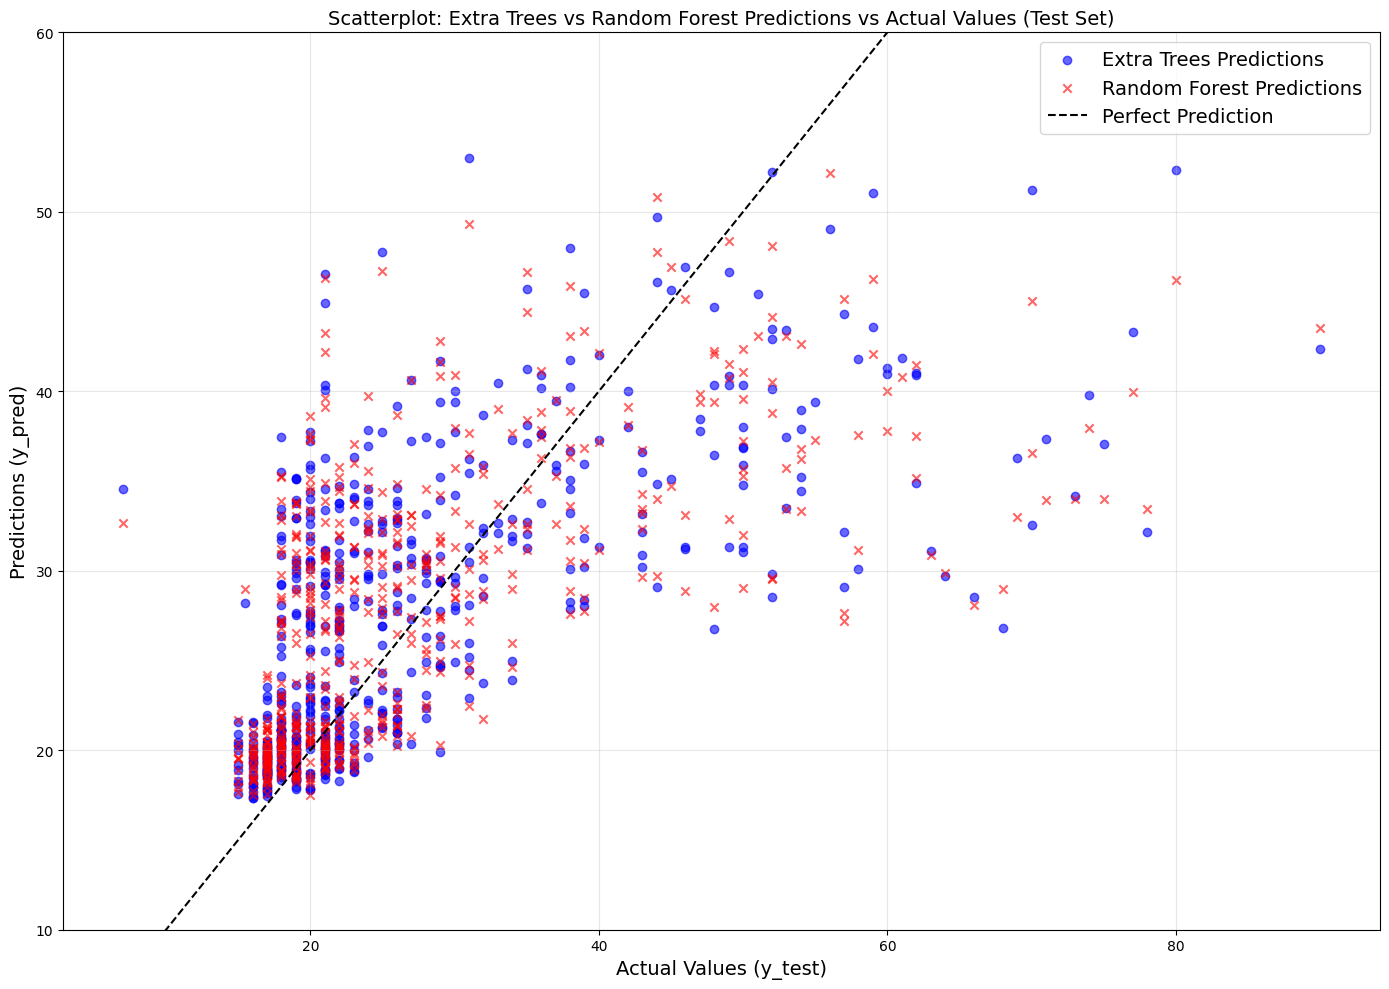

In [37]:
plt.figure(figsize=(14, 10))

# Scatter plot for Extra Trees and Random Forest predictions
plt.scatter(y_test, y_pred_etr, alpha=0.6, color='blue', label='Extra Trees Predictions', marker='o')
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='red', label='Random Forest Predictions', marker='x')

# Perfect Prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--', label='Perfect Prediction')
plt.ylim(10, 60)  

# Labels and title
plt.title("Scatterplot: Extra Trees vs Random Forest Predictions vs Actual Values (Test Set)", fontsize=14)
plt.xlabel("Actual Values (y_test)", fontsize=14)
plt.ylabel("Predictions (y_pred)", fontsize=14)

# Larger legend text
plt.legend(fontsize=14)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [38]:
y_rf = optimized_rf.predict(df[2933:])
results = pd.DataFrame({
    'Id': eval_df['Id'],  
    'Predicted': y_rf
})

filename = f"submission_rf_{rmse_rf:.5f}.csv" 
results.to_csv(filename, index=False) 

In [39]:
y_etr = optimized_etr.predict(df[2933:])
results = pd.DataFrame({
    'Id': eval_df['Id'],  
    'Predicted': y_etr
})

filename = f"submission_etr_{rmse_etr:.5f}.csv"  
results.to_csv(filename, index=False) 